In [19]:
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.feature_selection import SelectKBest, chi2

from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter


from random import sample
from collections import defaultdict
from statistics import median
from pandarallel import pandarallel
import csv
import time
from pathlib import Path

## Data preparation

In [ ]:
# MAKE FVL and RES datasets
for kind in ['fvl', 'res']:
    target='PATIENT'
    cases = pd.read_csv('../data/hcl/{}_cases.csv'.format(kind), index_col=0)
    cases[target] = 'case'
    controls = pd.read_csv("../data/hcl/{}_controls.csv".format(kind), index_col=0)
    controls[target] = 'control'

    df = pd.concat([cases, controls], ignore_index=True, sort=False)
    labels = list(df[target].values)

    # remove ABS from dataset
    cols = [c for c in df.columns if c.lower()[:3] != 'abs']
    df=df[cols]

    df = df[df.select_dtypes([np.number]).columns].dropna(axis='columns')
    non_na_features = list(df)

    df = df[non_na_features]
    df[target] = labels
    df.to_csv('../data/hcl/{}.csv'.format(kind))

## Info based

In [20]:
def iind(matrix, alpha = 0.5):
    p = alpha
    matrix = matrix[matrix.sum(axis = 1) > 0.0]
    s = matrix.values.sum()
    if s == 0:
        raise Exception('Sum of matrix is equal to 0')
    matrix = matrix / s
    m1 = matrix.sum(axis = 1)
    m2 = matrix.sum(axis = 0)
    outer_p = np.outer(m1, m2) 
    factor = 1 / (p-1)
    s = np.divide(np.power(matrix,p),np.power(outer_p,(p-1))).sum().sum()
    dividend = np.log(s)
    divisor = (np.log(np.sum(np.power(m2,(2-p)))))
    return dividend / divisor  

In [21]:
def leave_one_out(m_case, m_control, feature_subset, row_num):
    a = m_case.iloc[[row_num],feature_subset]
    b = m_control.iloc[:,feature_subset]
    partial_res = iind(a.append(b, ignore_index=True)) - iind(m_control.iloc[:,feature_subset])
    results = []

    for i, feature_num in enumerate(feature_subset):
        c = feature_subset.copy()
        c.remove(feature_num)
        a1 = m_case.iloc[[row_num], c]
        b1 = m_control.iloc[:, c]
        ind = iind(a1.append(b1, ignore_index=True)) - iind(m_control.iloc[:,c])
        results.append(ind)
    res = np.subtract(np.array([partial_res]),  np.array([results]))
    return res[0]

In [22]:
def apply_iind(m_case, m_control, features_num, row_num, k):
    feature_subset = sample(range(0, features_num), k)
    try:
        results = leave_one_out(m_case,m_control,feature_subset, row_num)
    except Exception as e:
        results = np.repeat(np.nan, k)

    return np.r_[np.array(feature_subset), results]

In [23]:
def plot_dict(d, labels, title=""):
    vals = []
    for k,v in d.items():
        vals.append((labels[k], v))
    vals = list(sorted(vals, key=lambda x: x[1], reverse=True))
    vals = list(zip(*vals))
    if len(vals) == 0:
        print("vals = '[]'")
        return
    x = list(vals[0])
    y = list(vals[1])  
    
    plt.figure(figsize=(15,15))
    plt.bar(range(len(y)), y, align='center')
    plt.xticks(range(len(x)), x, rotation=90)
    plt.title(title)
    plt.show()
    return x, y

In [24]:
def get_score(feature_ind_vals, feature_ind_to_name, all_measurements, plot=False):
    feature_median = dict()
    for feature_ind, vals in feature_ind_vals.items():
        median = np.median(vals)
        if feature_ind not in all_measurements:
            all_measurements[feature_ind] = vals
        else:
            all_measurements[feature_ind].extend(vals)
        feature_median[feature_ind] = median            
            
    if plot:
        plot_dict(feature_median, feature_ind_to_name, "patient")
        
#     imp_list = list(map(lambda x: x[0], sorted(feature_median.items(), key=lambda x: x[1], reverse=True)))

    return feature_median

In [25]:
def func_(col, m, m2, features_count, i, k):
    return apply_iind(m, m2, features_count, i, k)

def collect_statistics(col, feature_ind_vals, k):
    control_res = col.tolist()
    for row_num, feature_num in enumerate(control_res):
        if row_num == k:
            break
        ind_val = control_res[row_num + k]
        if not np.isnan(ind_val):
            feature_ind_vals[int(feature_num)].append(ind_val)

In [26]:
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [27]:
def save_feats(k, patient_id, feats):
    with open('k{}_patient{}.csv'.format(k,patient_ind),'w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['feat','score'])
        for row in feats:
            csv_out.writerow(row)
            
def save_names(feats_to_names):
    with open('feat_to_name.csv', 'w') as f:
        w = csv.DictWriter(f, feats_to_names.keys())
        w.writeheader()
        w.writerow(feats_to_names)

In [28]:
def collect_ind_to_name(m):
    feature_ind_to_name = dict()
    for i, feature_name in enumerate(m.columns):
        feature_ind_to_name[i] = feature_name
    save_names(feature_ind_to_name)
#     print(feature_ind_to_name)
    return feature_ind_to_name

In [29]:
def info_based(X_train, y_train, features_subset_size, iters, subset, save, read):
    X_train[TARGET] = y_train
    m_cases = X_train[X_train[TARGET] == CASE]
    m_controls = X_train[X_train[TARGET] == CONTROL]
    del m_cases[TARGET]
    del m_controls[TARGET]    
    
    start = time.time()
    feature_ind_to_name = collect_ind_to_name(m_cases)
    FEATURES_COUNT = m_cases.shape[1]
    print('FEATURES COUNT', FEATURES_COUNT)
    
    all_measurements = dict()
    importance_per_patient=dict()
    for patient_ind, ind_row in enumerate(m_cases.iterrows()):
        # Perform FS algorithm
        print("Starting for k = ", features_subset_size, ", patient = ", ind_row[0],  "(i={})...".format(patient_ind))
        
        if not read:
            d = pd.DataFrame(-1, index=np.arange(2*features_subset_size), columns=[i+1 for i in range(iters)])
            d = d.transpose()
            d = d.parallel_apply(lambda col: func_(col, m_cases, m_controls, FEATURES_COUNT, patient_ind, features_subset_size), axis=1)

        path = './{}/{}/{}/{}/{}'.format(DATE, KIND, iters, features_subset_size, subset)
        if save:
            d_to_write = d.to_frame()
            d_to_write.columns = d_to_write.columns.astype(str)
            # ./date/(fvl|res)/(iterations)/(features_subset_size)/(subset)/patient_id(absolute in whole dataset).
            # i.e. ./18_10_2020/fvl/200000/15/2/13.parquet
            Path(path).mkdir(parents=True, exist_ok=True)
            d_to_write.to_parquet(path + '/{}.parquet'.format(ind_row[0]))
            print("Result saved for k = ", features_subset_size, ", patient = ", ind_row[0], "...")
        if read:
            d = pd.read_parquet(path + '/{}.parquet'.format(ind_row[0])).iloc[:,0]
    
        # collect results
        feature_ind_vals = defaultdict(list)
        d.apply(lambda row: collect_statistics(row,feature_ind_vals, features_subset_size))
        get_score(feature_ind_vals, feature_ind_to_name, all_measurements)
        
    all_measurements_medians = dict()
    for feature_ind, vals in all_measurements.items():
        all_measurements_medians[feature_ind] = median = np.median(vals)
    end = time.time()
    print('Elapsed: ', end - start)
    
    return [all_measurements_medians[i] for i in range(0,FEATURES_COUNT)]
    
#     selected_fs, iind_val = plot_dict(all_measurements_medians, feature_ind_to_name, "median of all measurements; features_subset_size = " + str(features_subset_size))
#     iind_median = np.median(iind_val)
#     selected_fs_reduced = list(map(lambda x: x[0],filter(lambda x: x[1] >= iind_median, zip(selected_fs, iind_val))))
    
#     if selected_fs_reduced:
#         print("Selected features count: ", len(selected_fs_reduced))
#         print(selected_fs_reduced)
#     else:
#         print("selected_fs_reduced was empty for k = ", features_subset_size)        
        


# Feature selection and classification benchmark

In [30]:
N_SPLITS = 5
RANDOM_STATE = 10
ITERATIONS=50000
FEATURES_SUBSET_SIZE=10
TARGET='PATIENT'
CASE='case'
CONTROL='control'
DATE = '18_10_2020'

# CHANGE FOR EACH NOTEBOOK
SUBSET = 0 #in range 0 to N_SPLITS-1
KIND = 'res'

In [31]:
class FeatureSelector:
    """Extracts subset of most informative features and provides rank of all features from train samples."""
    def __init__(self, name):
        self.name = name
        self.features = features
        
    def get_features_importances(self):
        return self.features_importances

In [32]:
class RandomForestSelector(FeatureSelector):
    def __init__(self, n_estimators=500):
        super().__init__('RandomForestSelector')
        self.forest = RandomForestClassifier(n_estimators=n_estimators, random_state=RANDOM_STATE)
        
    def fit(self, X_train, y_train, subset_no):
        self.forest.fit(X_train, y_train)
        self.features_importances = self.forest.feature_importances_

In [33]:
class LassoSelector(FeatureSelector):
    def __init__(self):
        pass
    
    def fit(self, X_train, y_train, subset_no):
        lasso = LassoCV(random_state=RANDOM_STATE).fit(X_train, [1 if p == 'case' else 0 for p in y_train])
        self.features_importances = np.abs(lasso.coef_)

In [34]:
class ElasticNetSelector(FeatureSelector):
    def __init__(self):
        pass
    
    def fit(self, X_train, y_train, subset_no):
        elastic = ElasticNetCV(random_state=RANDOM_STATE).fit(X_train, [1 if p == 'case' else 0 for p in y_train])
        self.features_importances = np.abs(elastic.coef_)

In [35]:
class MCFSSelector(FeatureSelector):
    def __init__(self):
        pass
    
    def fit(self, X_train, y_train, subset_no):
        r.library("rmcfs")
        r.library("dplyr")

        original_features = X_train.columns.values
        X_train.columns = ['f' + str(i+1) for i, _ in enumerate(X_train.columns.values)]
        X_train[TARGET] = y_train

        with localconverter(ro.default_converter + pandas2ri.converter):
            r_from_pd_df = ro.conversion.py2rpy(X_train)

        r.assign('df1', r_from_pd_df)
        r('result <- mcfs(PATIENT ~ ., df1, cutoffPermutations = 30, seed = 2, threadsNumber = 16)')
        r('RI <- result$RI')
        result = r['result']
        ri = r['RI']

        with localconverter(ro.default_converter + pandas2ri.converter):
            pd_from_r_df = ro.conversion.rpy2py(ri)
        
        features_to_ri = dict()
        
        for _, row in pd_from_r_df.iterrows():
            features_to_ri[row['attribute']] = row['RI']

        del X_train[TARGET]
        X_train.columns = original_features
        self.features_importances = [features_to_ri['f' + str(i+1)] for i in range(0, len(original_features))]

In [36]:
class ITSelector(FeatureSelector):
    def __init__(self, iterations, features_subset_size):
        super().__init__('ITSelector')
        self.iterations = iterations
        self.features_subset_size = features_subset_size
    
    def fit(self, X_train, y_train, subset_no):
        self.features_importances = info_based(X_train, y_train, self.features_subset_size, self.iterations, subset_no, False, True)


In [37]:
class SelectKBestSelector(FeatureSelector):
    def __init__(self):
        pass
    
    def fit(self, X_train, y_train, subset_no):
        model = SelectKBest(chi2, k='all').fit(X_train, y_train)
        self.features_importances = model.scores_

In [38]:
class RandomCorrelatedRemovalSelector(FeatureSelector):
    def __init__(self):
        pass    

In [39]:
class FeatureSelectorsAggregator:
    """Aggregates partial feature selections obtained from FeatureSelectors."""
    def __init__(self, feature_selectors):
        self.name = 'FeatureSelectorsAggregator'
        self.feature_selectors = feature_selectors
        
    def set_k(self, k):
        self.k = k
        
    def get_features_importances(self):
        return self.features_importances
    
    def get_features_subset(self):
        names_importances  = list(zip(self.features_names, self.features_importances))
        names_importances = sorted(names_importances, key=lambda x: -x[1])
        return [feature_importance[0] for feature_importance in names_importances[:self.k]]
    
    def fit(self, X_train, y_train, subset_no):
        self.X_train = X_train
        self.features_names = list(X_train.columns.values)
        features_importances_list = []
        for f_selector in self.feature_selectors:
            f_selector.fit(X_train, y_train, subset_no)
            features_importances_list.append(f_selector.get_features_importances())
            
        # TODO Perform feature aggregation
        self.features_importances = features_importances_list[0]
    
    def plot_importances(self):
        if TARGET in self.X_train:
            del self.X_train[TARGET]
        feature_importance = pd.Series(index = self.X_train.columns, data = self.features_importances).dropna()
        feature_importance.sort_values().tail(90).plot(kind = 'bar', figsize = (18,6))
        plt.show()

In [40]:
class CVEvaluator:
    """Evaluate performance of feature selection and classification model with leave-one-out cross validation
        with n subsets (folds) of the whole dataset. For each iteration find the best classificator
        for current train/test split by performing GridSearchCV on the current train data and asses its performance
        on current test set. The results for each split are averaged and are the approximation of the performance
        of the final model.
            
        If n = 1, the best model is created by selecting features with FeatureSelectorsAggregator
        and performing GridSearchCV on the whole dataset to find the most accurate/sensitive classifier.
        """
    def __init__(self, n_splits, fs_aggregator, labels, data, kind, clfs):
        """
        Init CVEvaluator.

        Args:
            n_splits: Number of subsets.
            fs_aggregator: FeatureSelectorsAggregator for feature selection at each split.
            labels: list of strings representing labels.
            data: Pandas dataframe containing samples in rows with len(features) columns each.
            kind: healthy, fvl, res.
            clf: classifier to be used for classification task.
        """
        self.n_splits = n_splits
        self.fs_aggregator = fs_aggregator
        self.labels = labels
        self.data = data
        self.kind = kind
        self.clfs = clfs
        
    def perform_evaluation(self):
        skf = StratifiedKFold(n_splits=self.n_splits, random_state=RANDOM_STATE, shuffle=True)
        
        for i, index in enumerate(skf.split(self.data, self.labels)):
            train_index, test_index = index
            X_train, X_test = self.data[self.data.index.isin(train_index)], self.data[self.data.index.isin(test_index)]
            y_train, y_test = [self.labels[i] for i in train_index], [self.labels[i] for i in test_index]        
            
            self.fs_aggregator.fit(X_train, y_train, i)
            self.fs_aggregator.plot_importances()
            f_subset = self.fs_aggregator.get_features_subset()
            print(f_subset)
            
            X_train, X_test = X_train[f_subset], X_test[f_subset]
            for clf in self.clfs:
                clf.fit(X_train, y_train)
                y_predicted = clf.predict(X_test)
                print(str(clf).upper())
                print(classification_report(y_test, y_predicted))

In [41]:
df = pd.read_csv('../data/hcl/{}.csv'.format(KIND), index_col=0)
labels = list(df[TARGET].values)

del df[TARGET]
features = list(df.columns)

# Random Forest feature selection

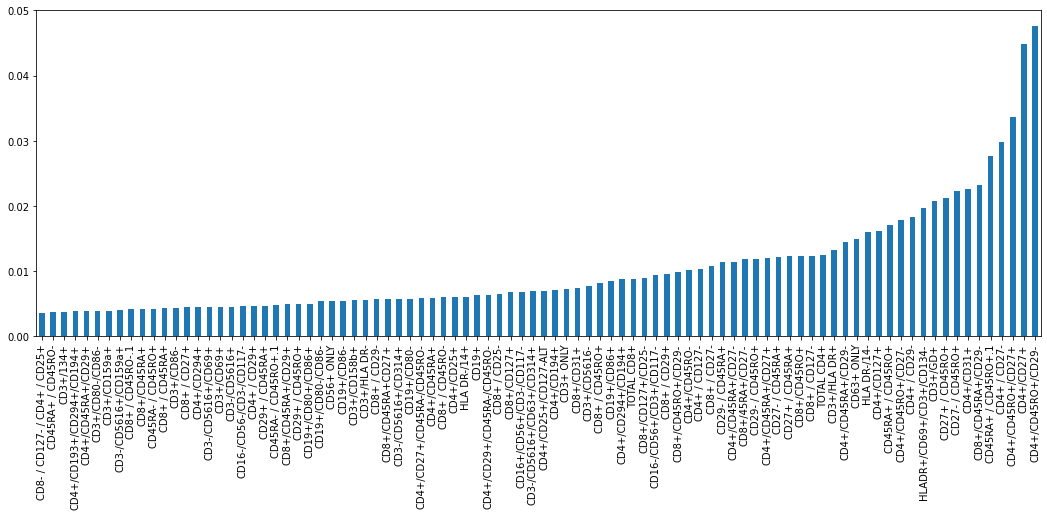

['CD4+/CD45RO+/CD29-', 'CD4+/CD27+', 'CD4+/CD45RO+/CD27+', 'CD4+ / CD27-', 'CD45RA+ / CD45RO+.1', 'CD8+/CD45RA+/CD29-', 'CD4+/CD31+', 'CD27- / CD45RO+', 'CD27+ / CD45RO+', 'CD3+/GD+']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.86      0.75      0.80         8
     control       0.50      0.67      0.57         3

    accuracy                           0.73        11
   macro avg       0.68      0.71      0.69        11
weighted avg       0.76      0.73      0.74        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
              

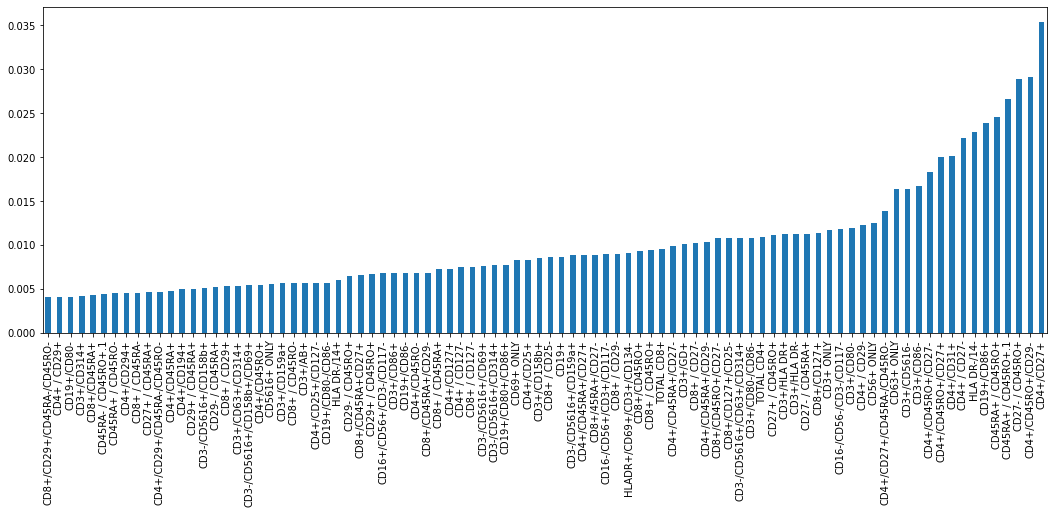

['CD4+/CD27+', 'CD4+/CD45RO+/CD29-', 'CD27- / CD45RO+', 'CD45RA+ / CD45RO+.1', 'CD45RA+ / CD45RO+', 'CD19+/CD86+', 'HLA DR-/14-', 'CD4+ / CD27-', 'CD4+/CD31+', 'CD4+/CD45RO+/CD27+']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      0.88      0.93         8
     control       0.75      1.00      0.86         3

    accuracy                           0.91        11
   macro avg       0.88      0.94      0.90        11
weighted avg       0.93      0.91      0.91        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                

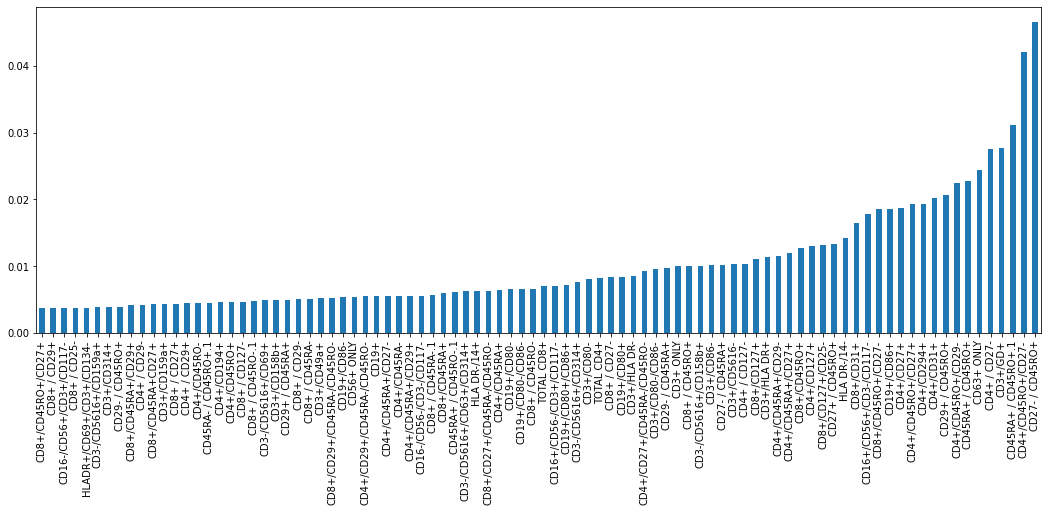

['CD27- / CD45RO+', 'CD4+/CD45RO+/CD27-', 'CD45RA+ / CD45RO+.1', 'CD3+/GD+', 'CD4+ / CD27-', 'CD63+ ONLY', 'CD45RA+ / CD45RO+', 'CD4+/CD45RO+/CD29-', 'CD29+ / CD45RO+', 'CD4+/CD31+']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.70      1.00      0.82         7
     control       1.00      0.25      0.40         4

    accuracy                           0.73        11
   macro avg       0.85      0.62      0.61        11
weighted avg       0.81      0.73      0.67        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
               

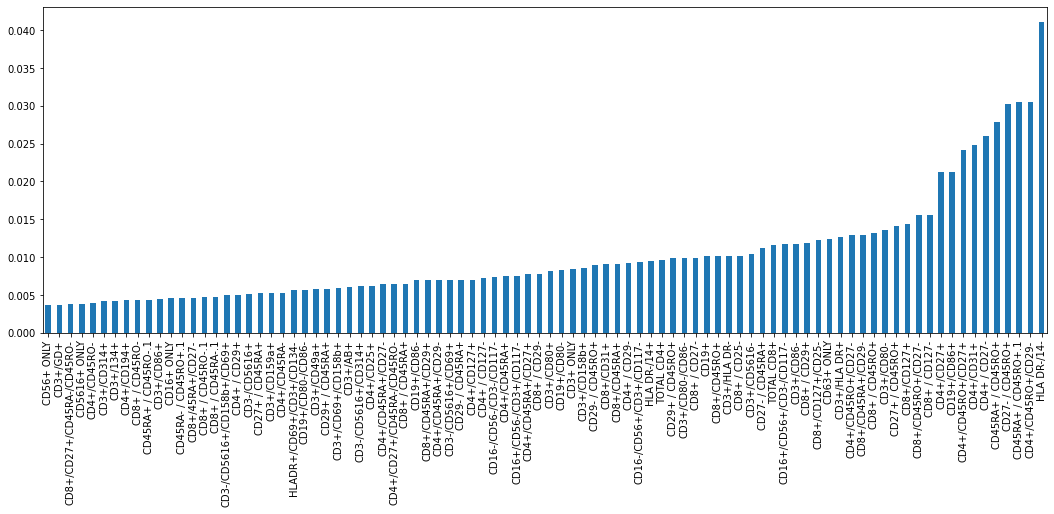

['HLA DR-/14-', 'CD4+/CD45RO+/CD29-', 'CD45RA+ / CD45RO+.1', 'CD27- / CD45RO+', 'CD45RA+ / CD45RO+', 'CD4+ / CD27-', 'CD4+/CD31+', 'CD4+/CD45RO+/CD27+', 'CD19+/CD86+', 'CD4+/CD27+']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      0.57      0.73         7
     control       0.57      1.00      0.73         4

    accuracy                           0.73        11
   macro avg       0.79      0.79      0.73        11
weighted avg       0.84      0.73      0.73        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                

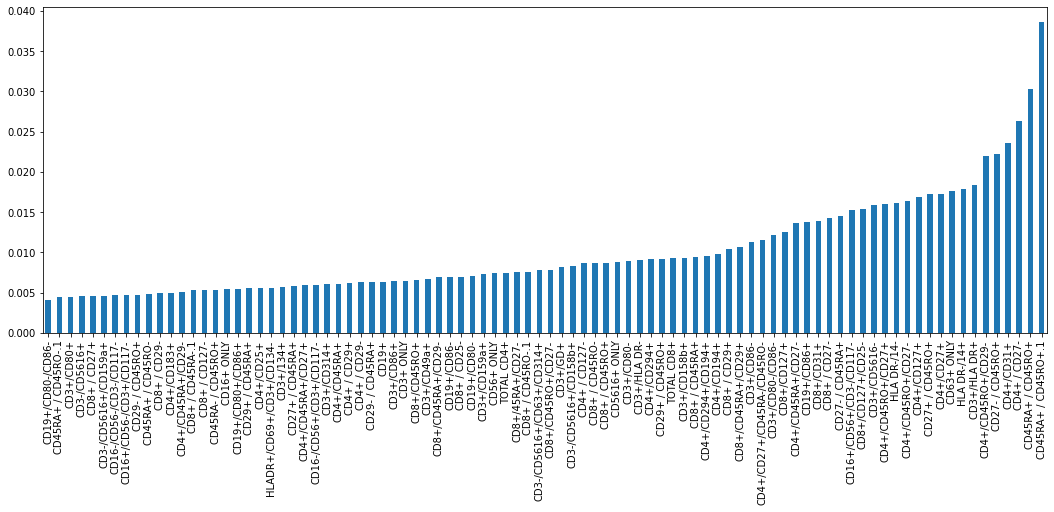

['CD45RA+ / CD45RO+.1', 'CD45RA+ / CD45RO+', 'CD4+ / CD27-', 'CD4+/CD31+', 'CD27- / CD45RO+', 'CD4+/CD45RO+/CD29-', 'CD3+/HLA DR+', 'HLA DR-/14+', 'CD63+ ONLY', 'CD4+/CD27+']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      0.43      0.60         7
     control       0.43      1.00      0.60         3

    accuracy                           0.60        10
   macro avg       0.71      0.71      0.60        10
weighted avg       0.83      0.60      0.60        10

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       

In [42]:
fs_selectors = [RandomForestSelector()]

fs_aggregator =  FeatureSelectorsAggregator(fs_selectors)
fs_aggregator.set_k(10)

neigh = KNeighborsClassifier(n_neighbors=3)
forest = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE)
clfs = [neigh, forest]
cv_evaluator = CVEvaluator(N_SPLITS, fs_aggregator, labels, df, KIND, clfs)
cv_evaluator.perform_evaluation()

# Information Theoretical approach feature selection

FEATURES COUNT 144
Starting for k =  10 , patient =  0 (i=0)...
Starting for k =  10 , patient =  1 (i=1)...
Starting for k =  10 , patient =  3 (i=2)...
Starting for k =  10 , patient =  6 (i=3)...
Starting for k =  10 , patient =  8 (i=4)...
Starting for k =  10 , patient =  9 (i=5)...
Starting for k =  10 , patient =  10 (i=6)...
Starting for k =  10 , patient =  12 (i=7)...
Starting for k =  10 , patient =  13 (i=8)...
Starting for k =  10 , patient =  14 (i=9)...
Starting for k =  10 , patient =  16 (i=10)...
Starting for k =  10 , patient =  17 (i=11)...
Starting for k =  10 , patient =  18 (i=12)...
Starting for k =  10 , patient =  19 (i=13)...
Starting for k =  10 , patient =  20 (i=14)...
Starting for k =  10 , patient =  22 (i=15)...
Starting for k =  10 , patient =  23 (i=16)...
Starting for k =  10 , patient =  24 (i=17)...
Starting for k =  10 , patient =  25 (i=18)...
Starting for k =  10 , patient =  26 (i=19)...
Starting for k =  10 , patient =  27 (i=20)...
Starting f

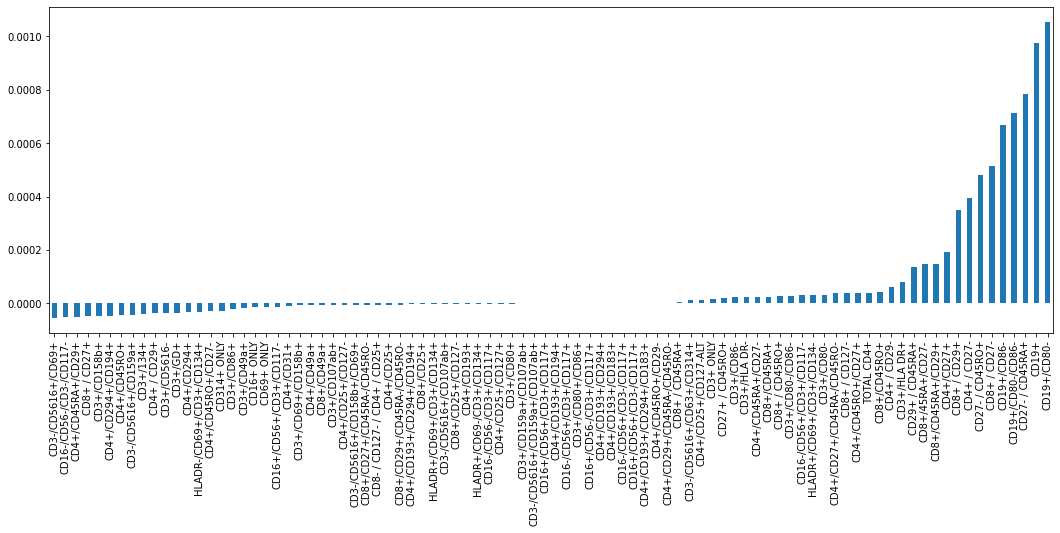

['CD19+/CD80-', 'CD19+', 'CD27- / CD45RA+', 'CD19+/CD80-/CD86-', 'CD19+/CD86-', 'CD8+ / CD27-', 'CD27- / CD45RO+', 'CD4+ / CD27-', 'CD8+ / CD29+', 'CD4+/CD27+']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.86      0.75      0.80         8
     control       0.50      0.67      0.57         3

    accuracy                           0.73        11
   macro avg       0.68      0.71      0.69        11
weighted avg       0.76      0.73      0.74        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LE

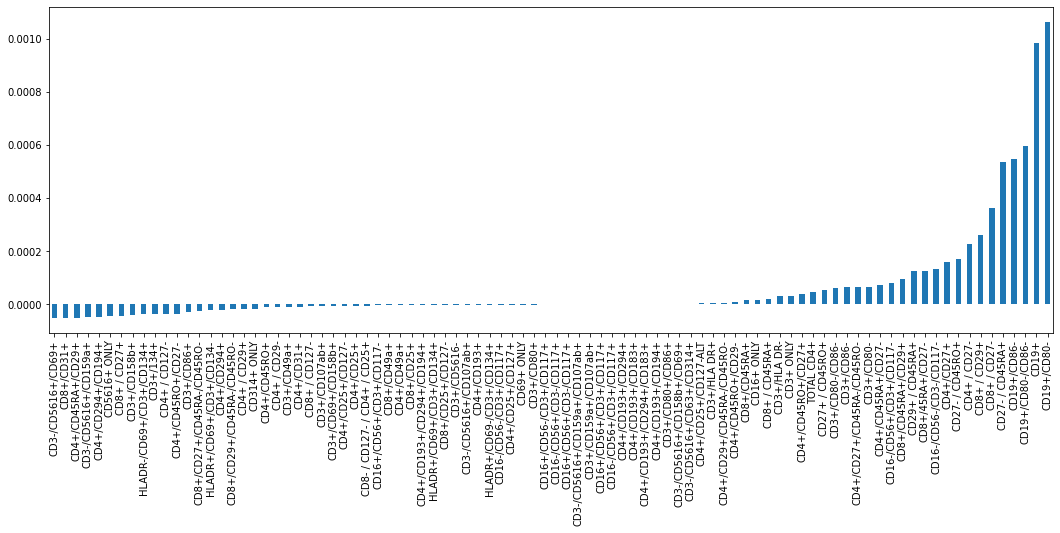

['CD19+/CD80-', 'CD19+', 'CD19+/CD80-/CD86-', 'CD19+/CD86-', 'CD27- / CD45RA+', 'CD8+ / CD27-', 'CD8+ / CD29+', 'CD4+ / CD27-', 'CD27- / CD45RO+', 'CD4+/CD27+']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      0.88      0.93         8
     control       0.75      1.00      0.86         3

    accuracy                           0.91        11
   macro avg       0.88      0.94      0.90        11
weighted avg       0.93      0.91      0.91        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LE

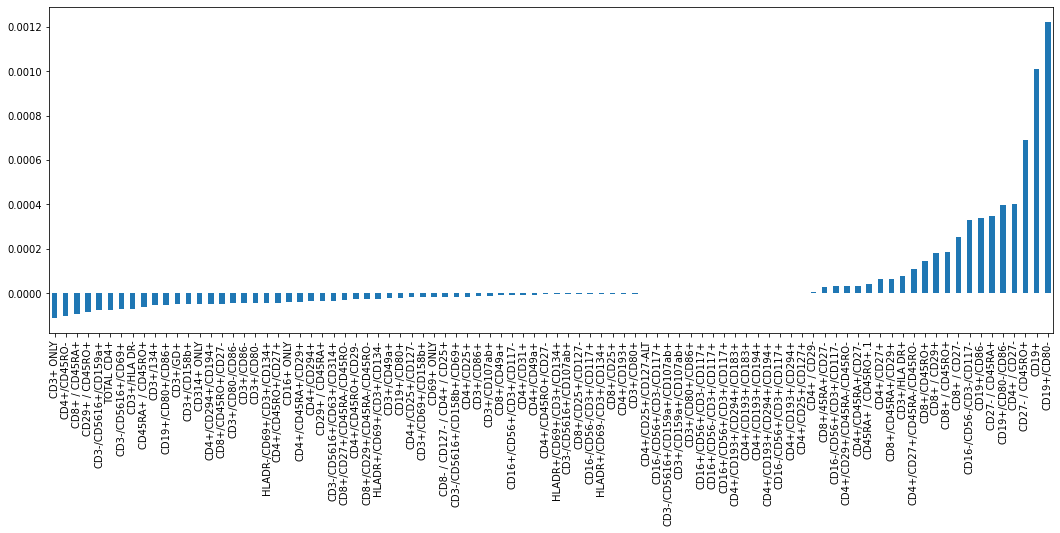

['CD19+/CD80-', 'CD19+', 'CD27- / CD45RO+', 'CD4+ / CD27-', 'CD19+/CD80-/CD86-', 'CD27- / CD45RA+', 'CD19+/CD86-', 'CD16-/CD56-/CD3-/CD117-', 'CD8+ / CD27-', 'CD8+ / CD45RO+']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.75      0.86      0.80         7
     control       0.67      0.50      0.57         4

    accuracy                           0.73        11
   macro avg       0.71      0.68      0.69        11
weighted avg       0.72      0.73      0.72        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                      

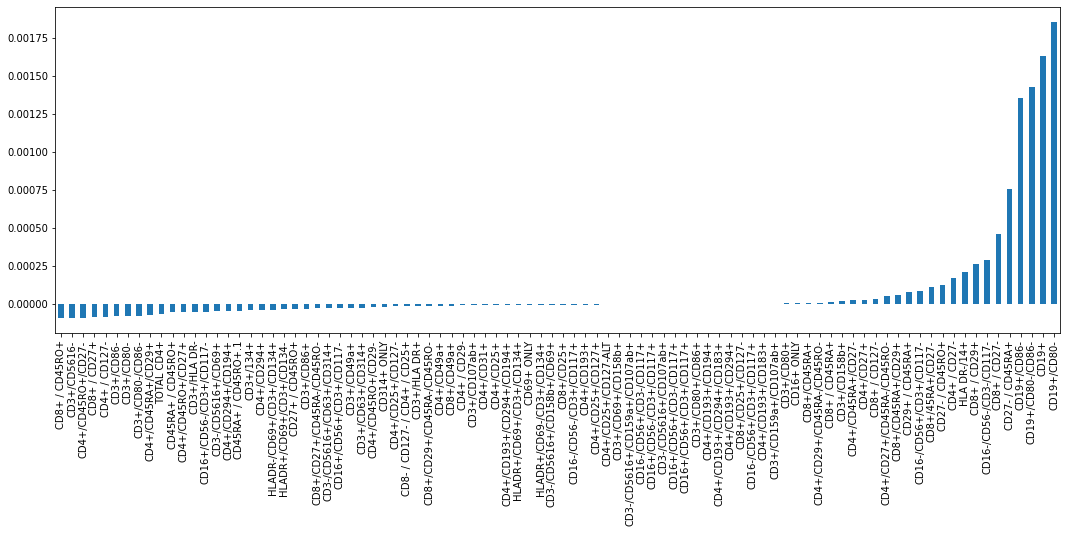

['CD19+/CD80-', 'CD19+', 'CD19+/CD80-/CD86-', 'CD19+/CD86-', 'CD27- / CD45RA+', 'CD8+ / CD27-', 'CD16-/CD56-/CD3-/CD117-', 'CD8+ / CD29+', 'HLA DR-/14+', 'CD4+ / CD27-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.88      1.00      0.93         7
     control       1.00      0.75      0.86         4

    accuracy                           0.91        11
   macro avg       0.94      0.88      0.90        11
weighted avg       0.92      0.91      0.91        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_S

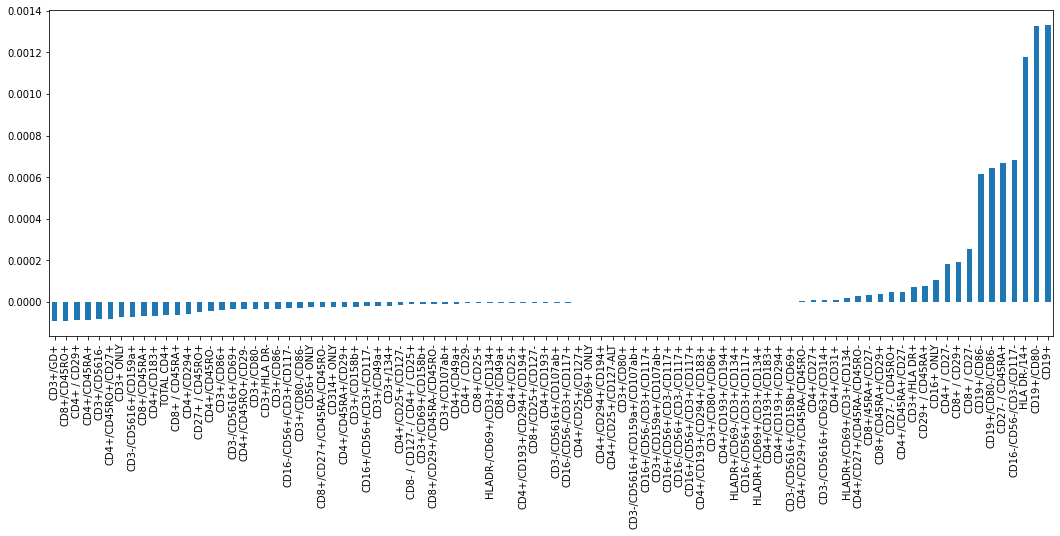

['CD19+', 'CD19+/CD80-', 'HLA DR-/14+', 'CD16-/CD56-/CD3-/CD117-', 'CD27- / CD45RA+', 'CD19+/CD80-/CD86-', 'CD19+/CD86-', 'CD8+ / CD27-', 'CD8+ / CD29+', 'CD4+ / CD27-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.67      0.57      0.62         7
     control       0.25      0.33      0.29         3

    accuracy                           0.50        10
   macro avg       0.46      0.45      0.45        10
weighted avg       0.54      0.50      0.52        10

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_S

In [44]:
fs_selectors = [ITSelector(ITERATIONS, FEATURES_SUBSET_SIZE)]

fs_aggregator =  FeatureSelectorsAggregator(fs_selectors)
fs_aggregator.set_k(10)

neigh = KNeighborsClassifier(n_neighbors=3)
forest = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE)
clfs = [neigh, forest]
cv_evaluator = CVEvaluator(N_SPLITS, fs_aggregator, labels, df, KIND, clfs)
cv_evaluator.perform_evaluation()

# Monte Carlo Feature Selection

R[write to console]: Ładowanie wymaganego pakietu: rJava

R[write to console]: 
  ########################
  # rmcfs version 1.3.1  #
  ########################
  If used please cite the following paper: 
  M. Draminski, J. Koronacki (2018), 
  rmcfs: An R Package for Monte Carlo Feature Selection and Interdependency Discovery,
  Journal of Statistical Software, vol 85(12), 1-28, doi:10.18637/jss.v085.i12.

R[write to console]: 
Dołączanie pakietu: ‘dplyr’


R[write to console]: Następujące obiekty zostały zakryte z ‘package:stats’:

    filter, lag


R[write to console]: Następujące obiekty zostały zakryte z ‘package:base’:

    intersect, setdiff, setequal, union




Checking input data...
Exporting params...
Exporting input data...
Running MCFS-ID...
Reading results...
Done.


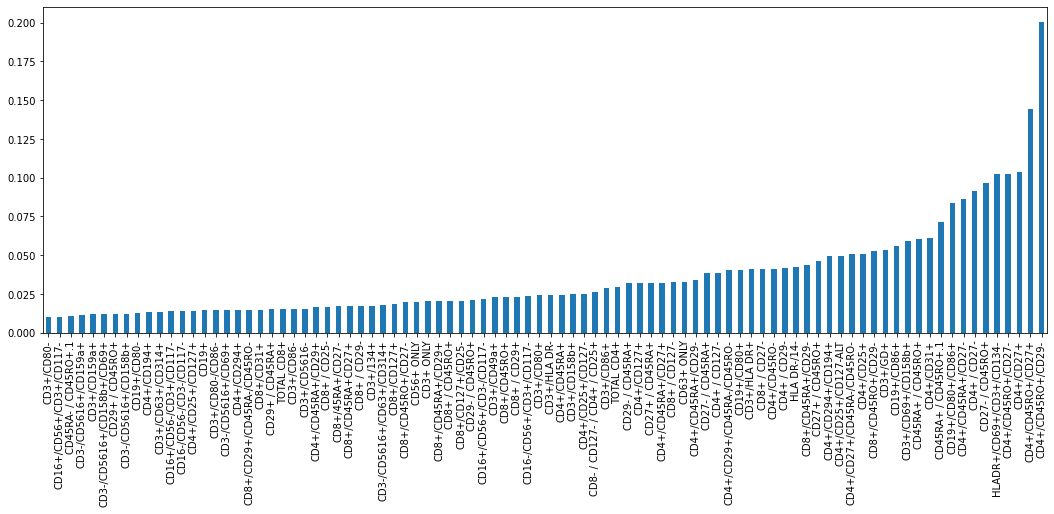

['CD4+/CD45RO+/CD29-', 'CD4+/CD45RO+/CD27+', 'CD4+/CD27+', 'CD4+/CD45RO+/CD27-', 'HLADR+/CD69+/CD3+/CD134-', 'CD27- / CD45RO+', 'CD4+ / CD27-', 'CD4+/CD45RA+/CD27-', 'CD19+/CD80+/CD86+', 'CD45RA+ / CD45RO+.1']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.80      1.00      0.89         8
     control       1.00      0.33      0.50         3

    accuracy                           0.82        11
   macro avg       0.90      0.67      0.69        11
weighted avg       0.85      0.82      0.78        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_

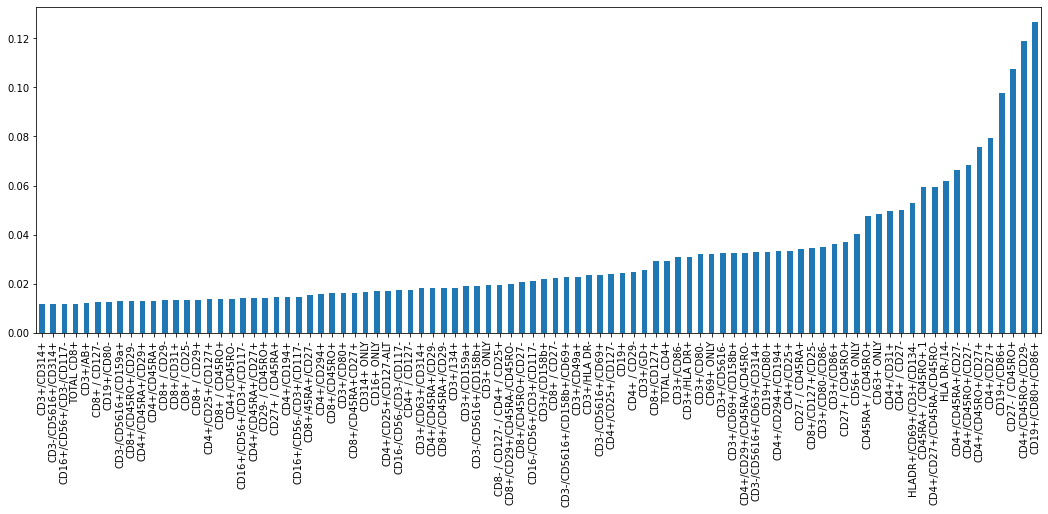

['CD19+/CD80+/CD86+', 'CD4+/CD45RO+/CD29-', 'CD27- / CD45RO+', 'CD19+/CD86+', 'CD4+/CD27+', 'CD4+/CD45RO+/CD27+', 'CD4+/CD45RO+/CD27-', 'CD4+/CD45RA+/CD27-', 'HLA DR-/14-', 'CD4+/CD27+/CD45RA-/CD45RO-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      0.75      0.86         8
     control       0.60      1.00      0.75         3

    accuracy                           0.82        11
   macro avg       0.80      0.88      0.80        11
weighted avg       0.89      0.82      0.83        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=N

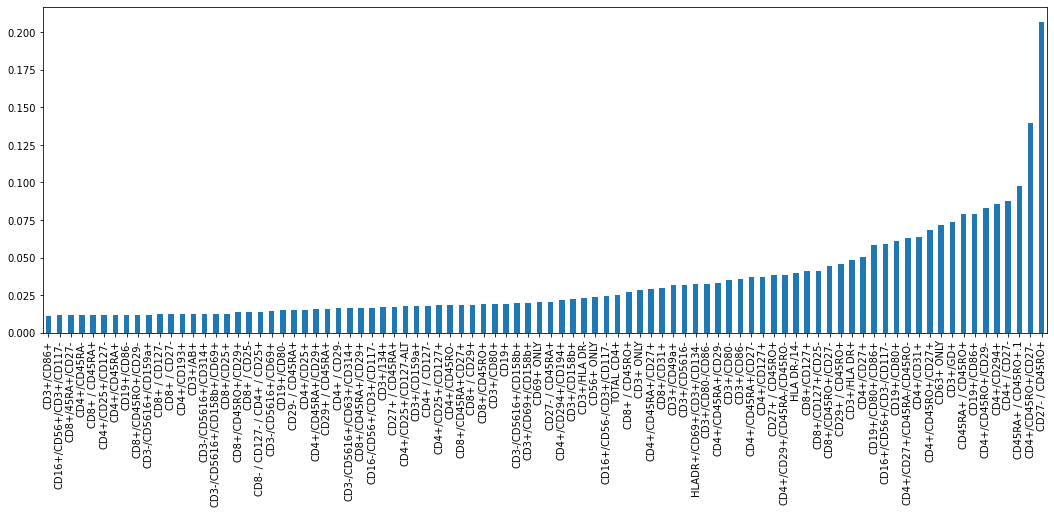

['CD27- / CD45RO+', 'CD4+/CD45RO+/CD27-', 'CD45RA+ / CD45RO+.1', 'CD4+ / CD27-', 'CD4+/CD294+', 'CD4+/CD45RO+/CD29-', 'CD19+/CD86+', 'CD45RA+ / CD45RO+', 'CD3+/GD+', 'CD63+ ONLY']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.67      0.86      0.75         7
     control       0.50      0.25      0.33         4

    accuracy                           0.64        11
   macro avg       0.58      0.55      0.54        11
weighted avg       0.61      0.64      0.60        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                  

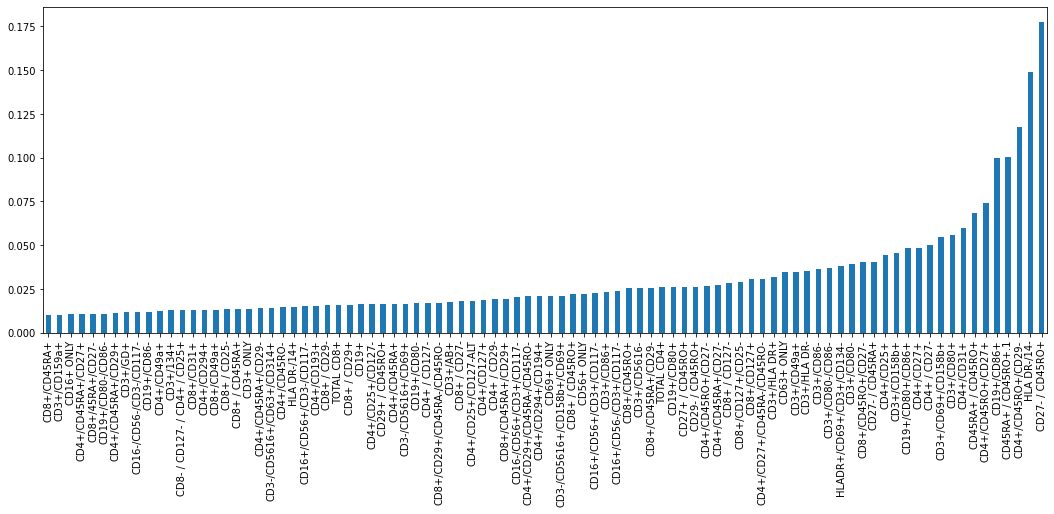

['CD27- / CD45RO+', 'HLA DR-/14-', 'CD4+/CD45RO+/CD29-', 'CD45RA+ / CD45RO+.1', 'CD19+/CD86+', 'CD4+/CD45RO+/CD27+', 'CD45RA+ / CD45RO+', 'CD4+/CD31+', 'CD3+/CD80+', 'CD3+/CD69+/CD158b+']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      0.71      0.83         7
     control       0.67      1.00      0.80         4

    accuracy                           0.82        11
   macro avg       0.83      0.86      0.82        11
weighted avg       0.88      0.82      0.82        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
          

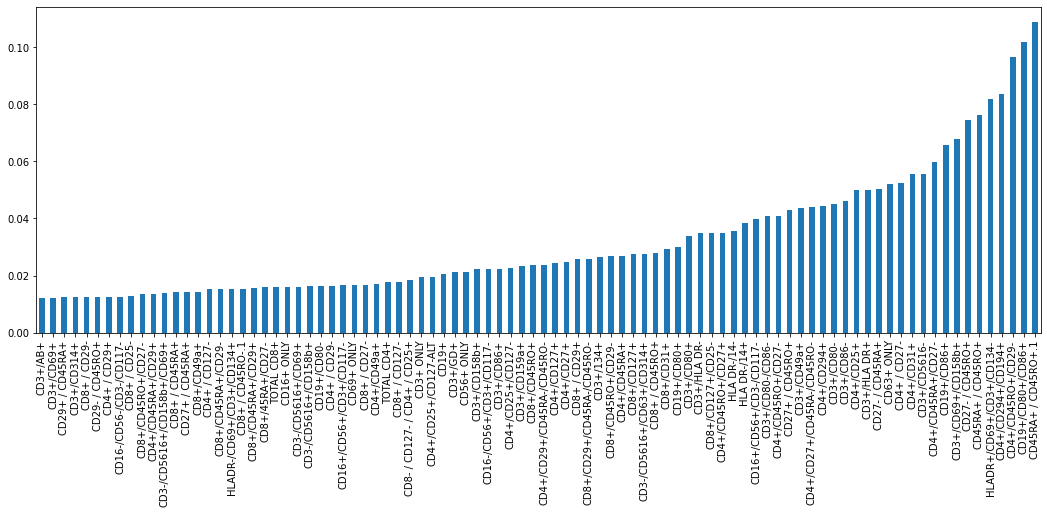

['CD45RA+ / CD45RO+.1', 'CD19+/CD80+/CD86+', 'CD4+/CD45RO+/CD29-', 'CD4+/CD294+/CD194+', 'HLADR+/CD69+/CD3+/CD134-', 'CD45RA+ / CD45RO+', 'CD27- / CD45RO+', 'CD3+/CD69+/CD158b+', 'CD19+/CD86+', 'CD4+/CD45RA+/CD27-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      1.00      1.00         7
     control       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMP

In [45]:
fs_selectors = [MCFSSelector()]

fs_aggregator =  FeatureSelectorsAggregator(fs_selectors)
fs_aggregator.set_k(10)

neigh = KNeighborsClassifier(n_neighbors=3)
forest = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE)
clfs = [neigh, forest]
cv_evaluator = CVEvaluator(N_SPLITS, fs_aggregator, labels, df, KIND, clfs)
cv_evaluator.perform_evaluation()

# Lasso Feature Selection

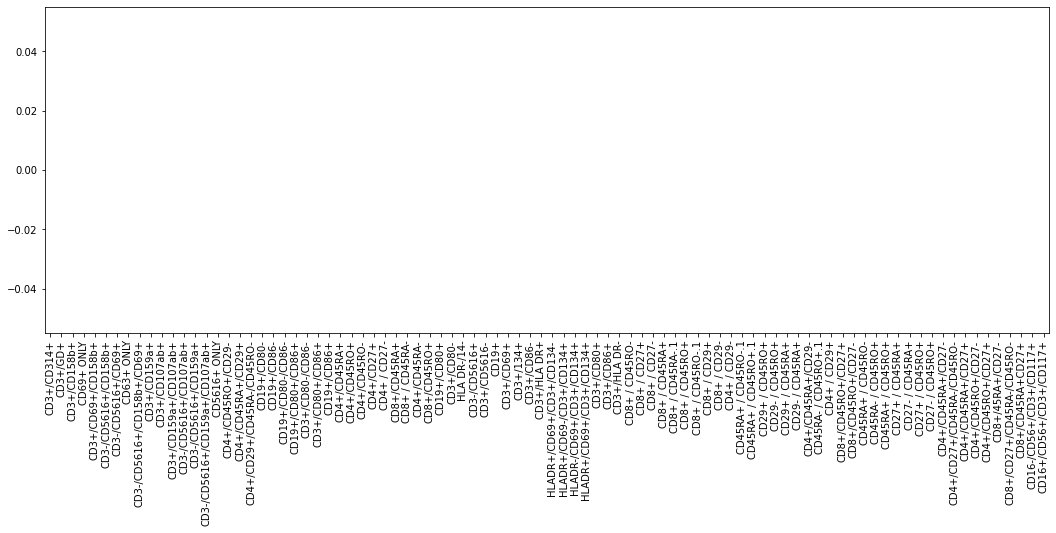

['HLA DR-/14+', 'HLA DR-/14-', 'CD3-/CD5616+', 'CD3+/CD5616-', 'CD19+', 'CD3+/CD69+', 'CD3+/134+', 'CD3+/HLA DR+', 'CD3+/HLA DR-', 'HLADR+/CD69+/CD3+/CD134-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      1.00      1.00         8
     control       1.00      1.00      1.00         3

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF

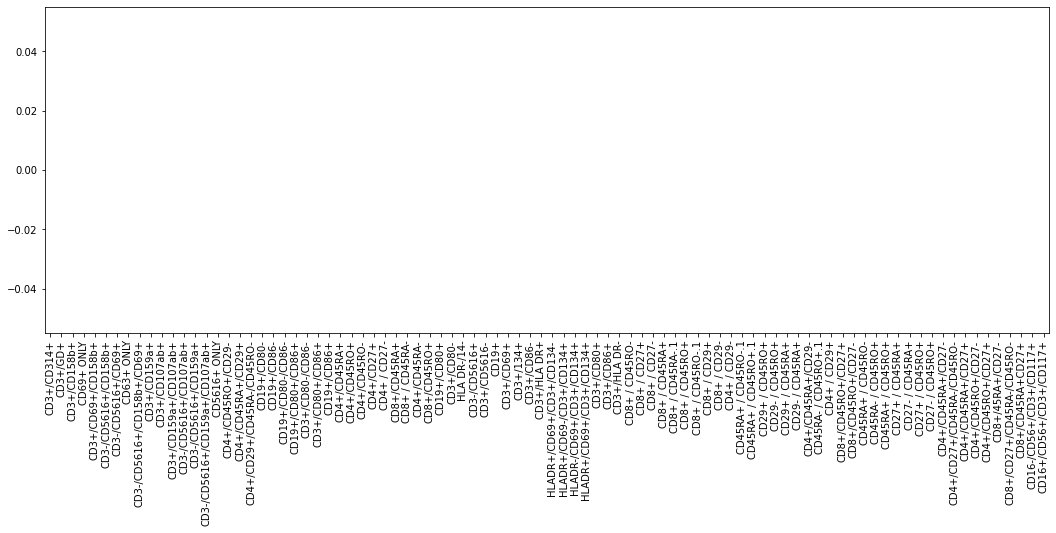

['HLA DR-/14+', 'HLA DR-/14-', 'CD3-/CD5616+', 'CD3+/CD5616-', 'CD19+', 'CD3+/CD69+', 'CD3+/134+', 'CD3+/HLA DR+', 'CD3+/HLA DR-', 'HLADR+/CD69+/CD3+/CD134-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      0.88      0.93         8
     control       0.75      1.00      0.86         3

    accuracy                           0.91        11
   macro avg       0.88      0.94      0.90        11
weighted avg       0.93      0.91      0.91        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF

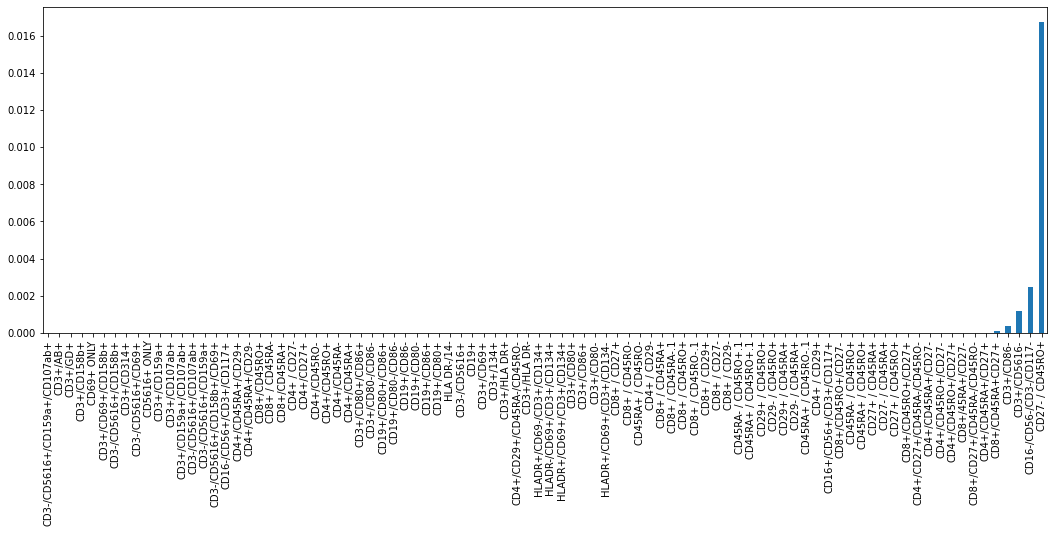

['CD27- / CD45RO+', 'CD16-/CD56-/CD3-/CD117-', 'CD3+/CD5616-', 'CD3+/CD86-', 'CD8+/CD45RA+CD27+', 'HLA DR-/14+', 'HLA DR-/14-', 'CD3-/CD5616+', 'CD19+', 'CD3+/CD69+']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.67      0.86      0.75         7
     control       0.50      0.25      0.33         4

    accuracy                           0.64        11
   macro avg       0.58      0.55      0.54        11
weighted avg       0.61      0.64      0.60        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMP

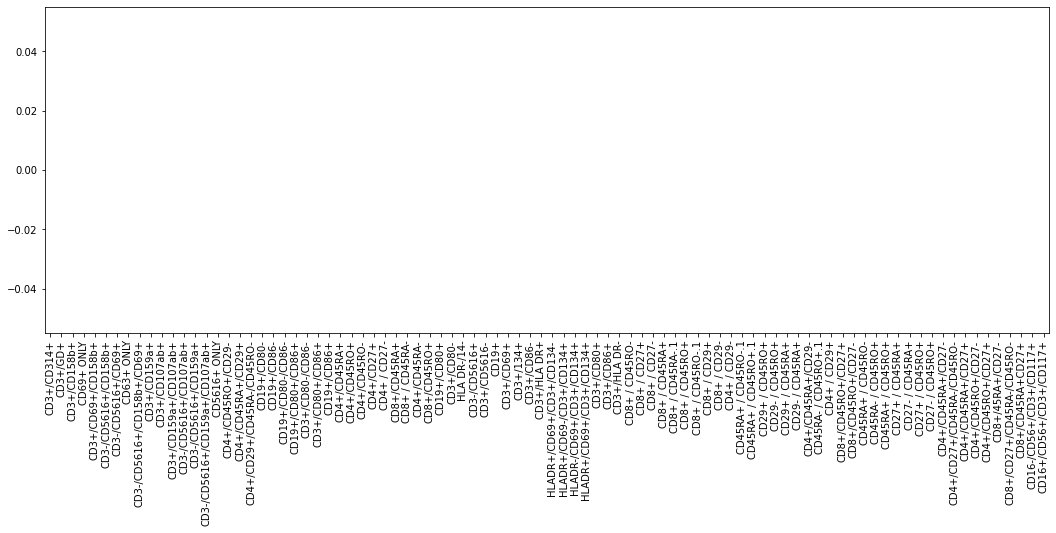

['HLA DR-/14+', 'HLA DR-/14-', 'CD3-/CD5616+', 'CD3+/CD5616-', 'CD19+', 'CD3+/CD69+', 'CD3+/134+', 'CD3+/HLA DR+', 'CD3+/HLA DR-', 'HLADR+/CD69+/CD3+/CD134-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.83      0.71      0.77         7
     control       0.60      0.75      0.67         4

    accuracy                           0.73        11
   macro avg       0.72      0.73      0.72        11
weighted avg       0.75      0.73      0.73        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF

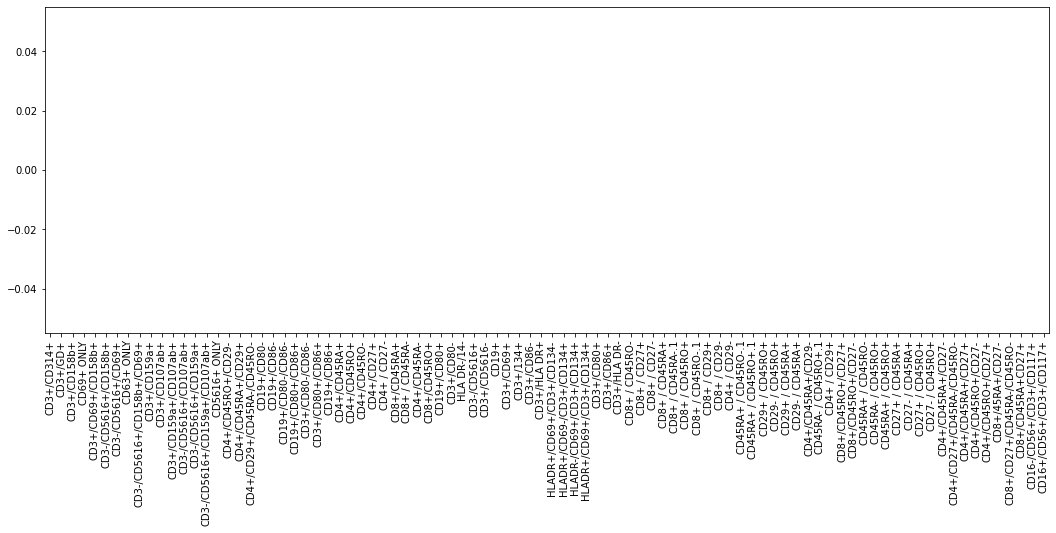

['HLA DR-/14+', 'HLA DR-/14-', 'CD3-/CD5616+', 'CD3+/CD5616-', 'CD19+', 'CD3+/CD69+', 'CD3+/134+', 'CD3+/HLA DR+', 'CD3+/HLA DR-', 'HLADR+/CD69+/CD3+/CD134-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.71      0.71      0.71         7
     control       0.33      0.33      0.33         3

    accuracy                           0.60        10
   macro avg       0.52      0.52      0.52        10
weighted avg       0.60      0.60      0.60        10

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF

In [46]:
fs_selectors = [LassoSelector()]

fs_aggregator =  FeatureSelectorsAggregator(fs_selectors)
fs_aggregator.set_k(10)

neigh = KNeighborsClassifier(n_neighbors=3)
forest = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE)
clfs = [neigh, forest]
cv_evaluator = CVEvaluator(N_SPLITS, fs_aggregator, labels, df, KIND, clfs)
cv_evaluator.perform_evaluation()

# Elastic Net Feature Selection

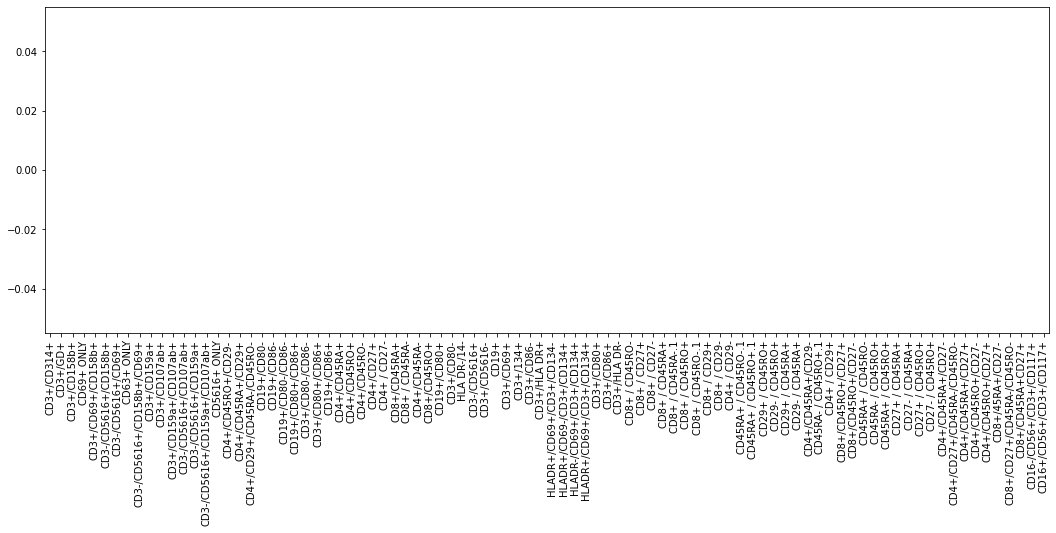

['HLA DR-/14+', 'HLA DR-/14-', 'CD3-/CD5616+', 'CD3+/CD5616-', 'CD19+', 'CD3+/CD69+', 'CD3+/134+', 'CD3+/HLA DR+', 'CD3+/HLA DR-', 'HLADR+/CD69+/CD3+/CD134-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      1.00      1.00         8
     control       1.00      1.00      1.00         3

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF

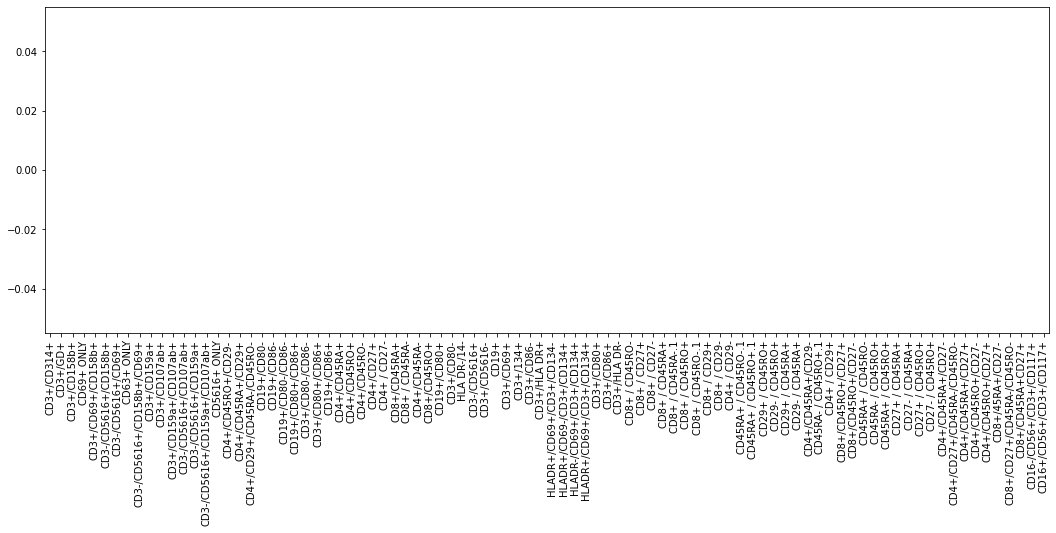

['HLA DR-/14+', 'HLA DR-/14-', 'CD3-/CD5616+', 'CD3+/CD5616-', 'CD19+', 'CD3+/CD69+', 'CD3+/134+', 'CD3+/HLA DR+', 'CD3+/HLA DR-', 'HLADR+/CD69+/CD3+/CD134-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      0.88      0.93         8
     control       0.75      1.00      0.86         3

    accuracy                           0.91        11
   macro avg       0.88      0.94      0.90        11
weighted avg       0.93      0.91      0.91        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF

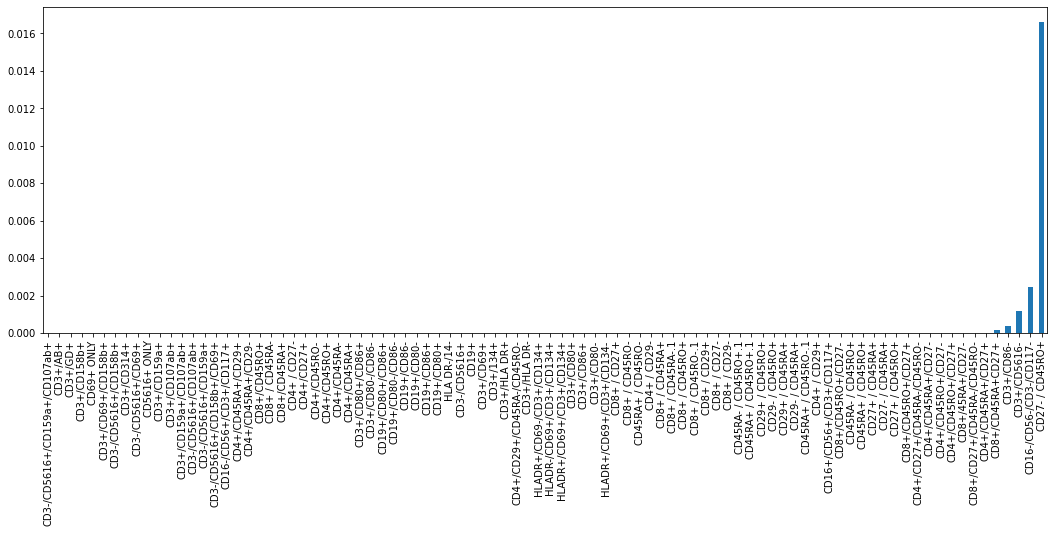

['CD27- / CD45RO+', 'CD16-/CD56-/CD3-/CD117-', 'CD3+/CD5616-', 'CD3+/CD86-', 'CD8+/CD45RA+CD27+', 'HLA DR-/14+', 'HLA DR-/14-', 'CD3-/CD5616+', 'CD19+', 'CD3+/CD69+']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.67      0.86      0.75         7
     control       0.50      0.25      0.33         4

    accuracy                           0.64        11
   macro avg       0.58      0.55      0.54        11
weighted avg       0.61      0.64      0.60        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMP

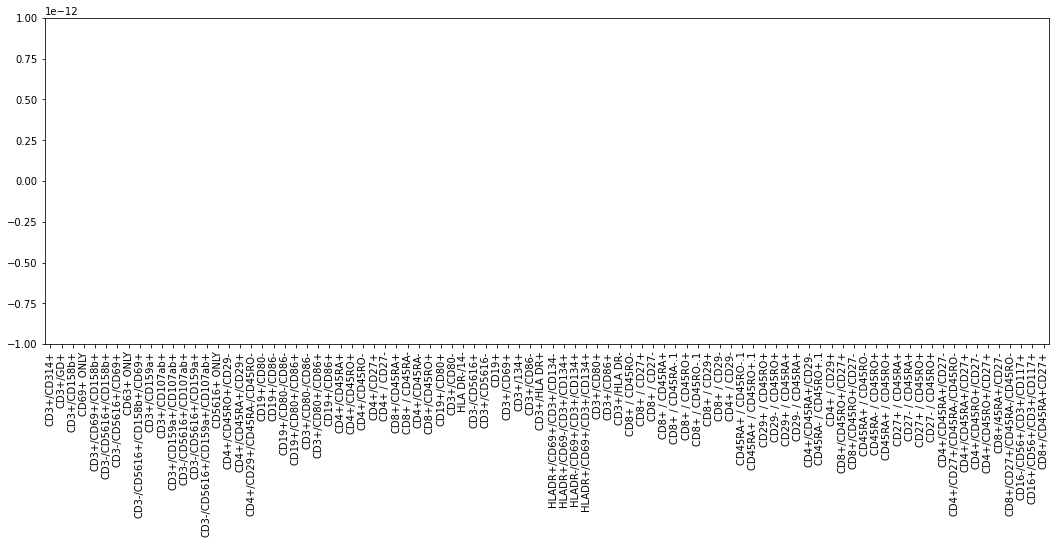

['CD8+/CD45RA+CD27+', 'HLA DR-/14+', 'HLA DR-/14-', 'CD3-/CD5616+', 'CD3+/CD5616-', 'CD19+', 'CD3+/CD69+', 'CD3+/134+', 'CD3+/HLA DR+', 'CD3+/HLA DR-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.83      0.71      0.77         7
     control       0.60      0.75      0.67         4

    accuracy                           0.73        11
   macro avg       0.72      0.73      0.72        11
weighted avg       0.75      0.73      0.73        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF=1, MIN

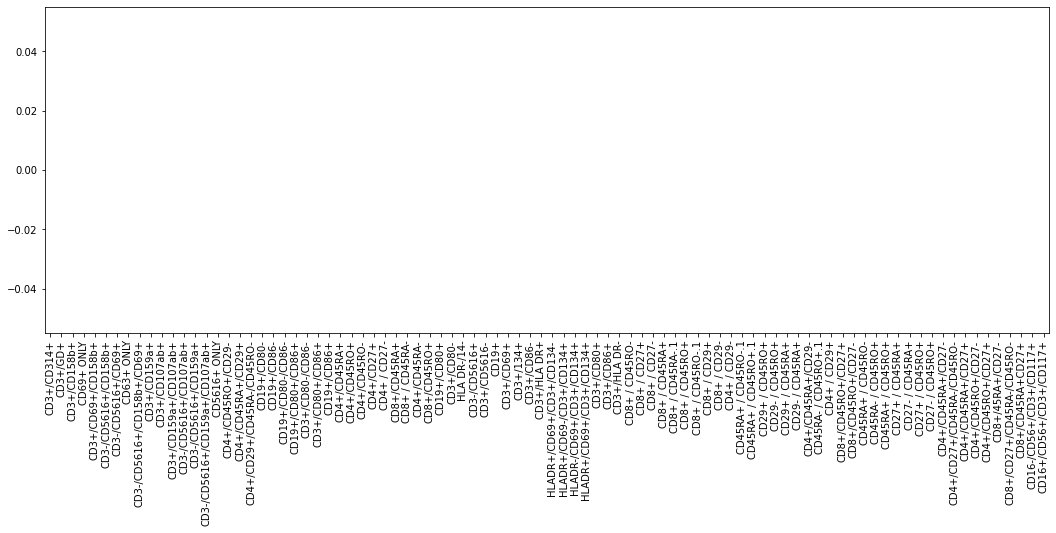

['HLA DR-/14+', 'HLA DR-/14-', 'CD3-/CD5616+', 'CD3+/CD5616-', 'CD19+', 'CD3+/CD69+', 'CD3+/134+', 'CD3+/HLA DR+', 'CD3+/HLA DR-', 'HLADR+/CD69+/CD3+/CD134-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.71      0.71      0.71         7
     control       0.33      0.33      0.33         3

    accuracy                           0.60        10
   macro avg       0.52      0.52      0.52        10
weighted avg       0.60      0.60      0.60        10

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF

In [47]:
fs_selectors = [ElasticNetSelector()]

fs_aggregator =  FeatureSelectorsAggregator(fs_selectors)
fs_aggregator.set_k(10)

neigh = KNeighborsClassifier(n_neighbors=3)
forest = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE)
clfs = [neigh, forest]
cv_evaluator = CVEvaluator(N_SPLITS, fs_aggregator, labels, df, KIND, clfs)
cv_evaluator.perform_evaluation()

# Chi-squared feature selection

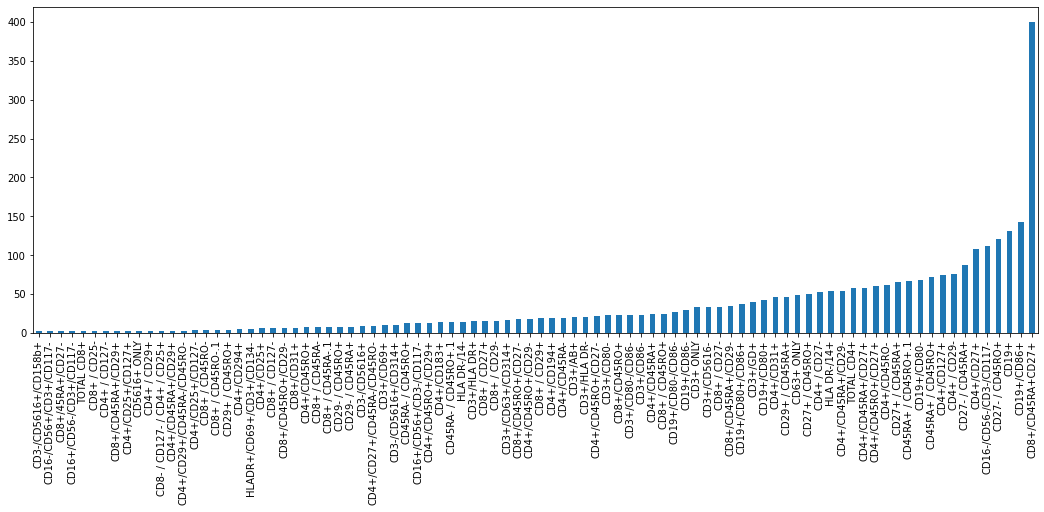

['CD19+/CD86+', 'CD19+', 'CD4+/CD27+', 'CD19+/CD80-', 'CD4+/CD45RO-', 'HLA DR-/14+', 'CD4+ / CD27-', 'CD19+/CD80+', 'CD19+/CD80+/CD86+', 'CD3+/CD5616-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.86      0.75      0.80         8
     control       0.50      0.67      0.57         3

    accuracy                           0.73        11
   macro avg       0.68      0.71      0.69        11
weighted avg       0.76      0.73      0.74        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF=1, MI

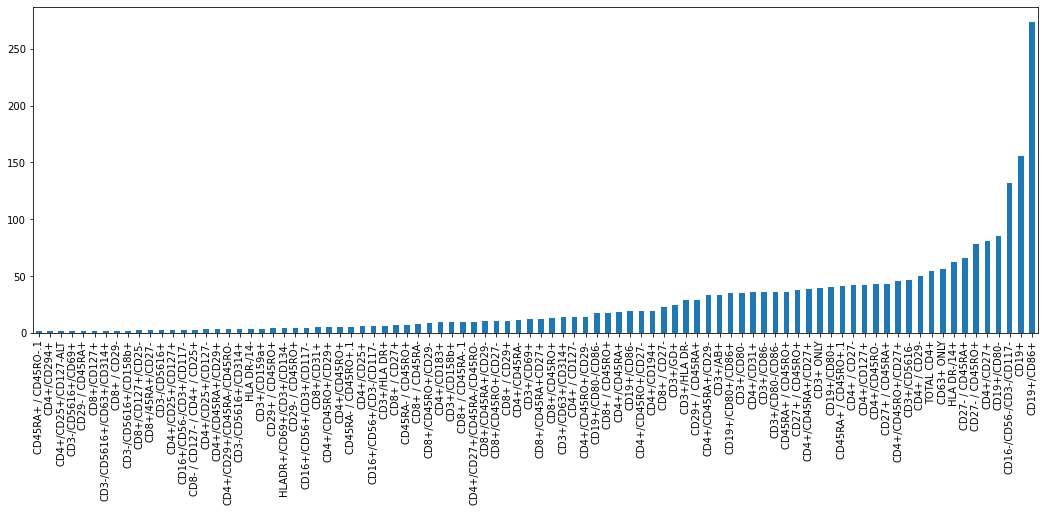

['CD19+/CD86+', 'CD19+', 'CD19+/CD80-', 'CD4+/CD27+', 'HLA DR-/14+', 'CD3+/CD5616-', 'CD4+/CD45RO-', 'CD4+ / CD27-', 'CD19+/CD80+', 'CD3+/CD80-/CD86-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       1.00      0.88      0.93         8
     control       0.75      1.00      0.86         3

    accuracy                           0.91        11
   macro avg       0.88      0.94      0.90        11
weighted avg       0.93      0.91      0.91        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF=1, MIN

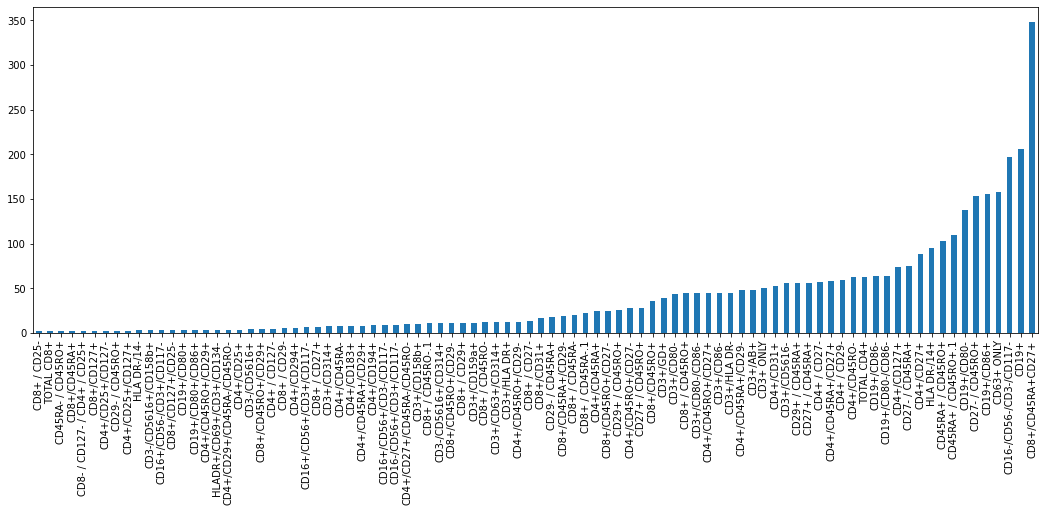

['CD19+', 'CD19+/CD86+', 'CD19+/CD80-', 'HLA DR-/14+', 'CD4+/CD27+', 'CD19+/CD80-/CD86-', 'CD19+/CD86-', 'CD4+/CD45RO-', 'CD4+ / CD27-', 'CD3+/CD5616-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.75      0.86      0.80         7
     control       0.67      0.50      0.57         4

    accuracy                           0.73        11
   macro avg       0.71      0.68      0.69        11
weighted avg       0.72      0.73      0.72        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF=1, MI

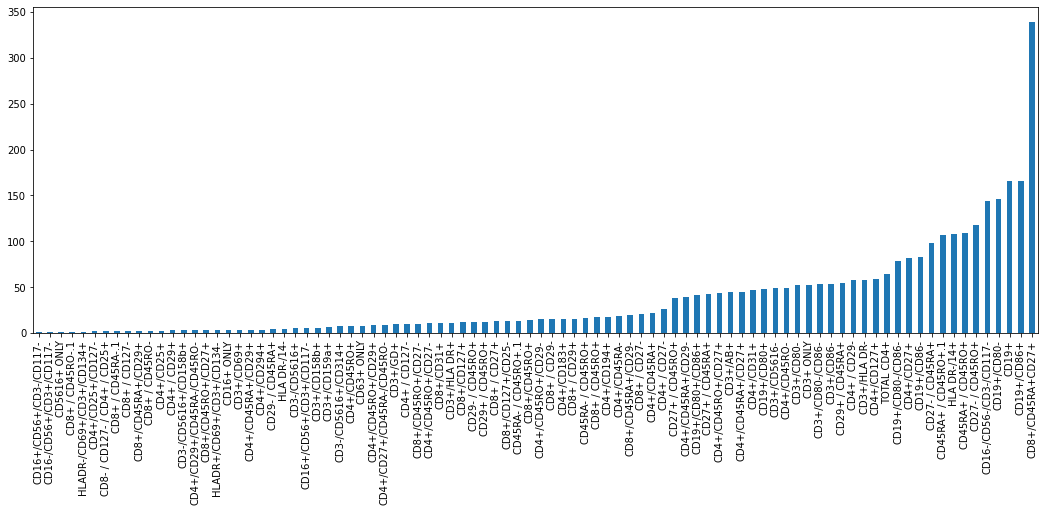

['CD19+/CD86+', 'CD19+', 'CD19+/CD80-', 'HLA DR-/14+', 'CD19+/CD86-', 'CD4+/CD27+', 'CD19+/CD80-/CD86-', 'CD3+/HLA DR-', 'CD3+/CD86-', 'CD3+/CD80-/CD86-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.83      0.71      0.77         7
     control       0.60      0.75      0.67         4

    accuracy                           0.73        11
   macro avg       0.72      0.73      0.72        11
weighted avg       0.75      0.73      0.73        11

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF=1, 

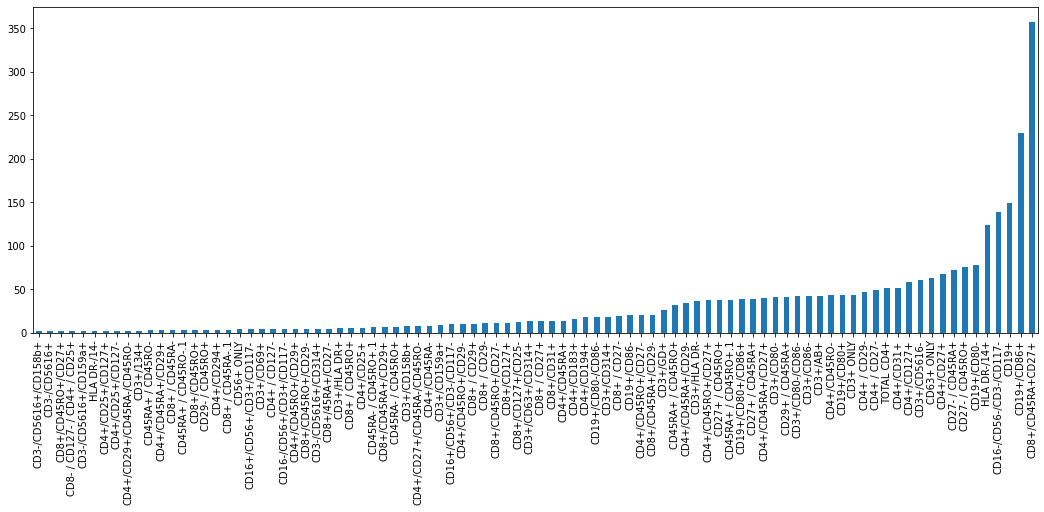

['CD19+/CD86+', 'CD19+', 'HLA DR-/14+', 'CD19+/CD80-', 'CD4+/CD27+', 'CD3+/CD5616-', 'CD4+ / CD27-', 'CD19+/CD80+', 'CD4+/CD45RO-', 'CD3+/CD86-']
KNEIGHBORSCLASSIFIER(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                     METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=3, P=2,
                     WEIGHTS='UNIFORM')
              precision    recall  f1-score   support

        case       0.80      0.57      0.67         7
     control       0.40      0.67      0.50         3

    accuracy                           0.60        10
   macro avg       0.60      0.62      0.58        10
weighted avg       0.68      0.60      0.62        10

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CLASS_WEIGHT=NONE,
                       CRITERION='GINI', MAX_DEPTH=NONE, MAX_FEATURES='AUTO',
                       MAX_LEAF_NODES=NONE, MAX_SAMPLES=NONE,
                       MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                       MIN_SAMPLES_LEAF=1, MIN_SAMPL

In [48]:
fs_selectors = [SelectKBestSelector()]

fs_aggregator =  FeatureSelectorsAggregator(fs_selectors)
fs_aggregator.set_k(10)

neigh = KNeighborsClassifier(n_neighbors=3)
forest = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE)
clfs = [neigh, forest]
cv_evaluator = CVEvaluator(N_SPLITS, fs_aggregator, labels, df, KIND, clfs)
cv_evaluator.perform_evaluation()